In [8]:
import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import re

import tensorflow as tf
from transformers import (
    DistilBertTokenizer, 
    TFDistilBertModel,
    BertTokenizer, TFBertModel,
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoModel, TFAutoModel
)

from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder,
    RobustScaler,
    LabelBinarizer
)
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    RandomForestClassifier, 
    VotingClassifier, 
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Database Loading and Extraction  

We have an excel sheet named "transactions_for_labelling.xlsx" and we are going to insert this into our transactions table. Now all of our transactions are labelled and we can used these to create our machine learning model.

In [9]:
db_path = 'transactions.db'
conn = sqlite3.connect(db_path)

# add the new column for the labels of our transactions
add_column_query = '''
ALTER TABLE transactions 
ADD COLUMN labels TEXT DEFAULT NULL;
'''

try:
    conn.execute(add_column_query)
    conn.commit()
except  sqlite3.OperationalError as e:
    print(f'An error occurred: {e}') # don't execute if the column already exists

An error occurred: duplicate column name: labels


In [10]:
labeled_df = pd.read_excel('transactions_for_labelling.xlsx')
labeled_df.head()

cursor = conn.cursor()

# update the labels based on the transaction_id from excel file
update_query = '''
UPDATE transactions
SET labels = ?
WHERE transaction_id = ?
'''
updated_data = labeled_df[['label','transaction_id']].values.tolist()
cursor.executemany(update_query, updated_data)
conn.commit()

/Users/kennethhahn/github/ML Personal Budgeter/venv/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning:

Data Validation extension is not supported and will be removed



In [18]:
# extract all transactions into DataFrame
extract_query = 'SELECT * FROM transactions'
txns_df = pd.read_sql_query(extract_query, conn)

txns_df.head()

,transaction_id,date,description,extended_details,amount,source,merchant,address,city,state,zip_code,category,labels,predicted_labels
0,39080184f8974ac2106f80c9b470f26ca8e55132a29296...,2024-10-02,In-N-Out Burger,IN-N-OUT ANAHEIM,-13.85,boa_credit,None,None,None,None,None,Restaurants/Dining,dining,dining
1,e71d36f8019636ff51d106a47227b9e445555da5248232...,2024-10-01,Payment to US Department Of Education,DEPT EDUCATION DES:STUDENT LN ID:6QCS48J968...,-885.73,boa_debit,None,None,None,None,None,Loans,debt,debt
2,19a88e101c0c0d72415064853fa56ffd25fd6f7abaeeb6...,2024-09-30,Transfer to Venmo,VENMO DES:PAYMENT ID:xxxxxxxxx8...,-15.00,boa_debit,None,None,None,None,None,Transfers,ignore,ignore
3,abead733580c30a9d32eccbb4d48740565ccef5aa0700c...,2024-09-30,Transfer from Venmo,VENMO DES:CASHOUT ID:xxxxxxxxx6...,205.00,boa_debit,None,None,None,None,None,Transfers,ignore,ignore
4,1950fd706e78b498ee29a07c8d56a95be891aa6807e75f...,2024-09-30,Vons,VONS #2041 GARDEN GROVE CA,-21.30,boa_credit,None,None,None,None,None,Groceries,groceries,dining


# Feature Engineering  

Let's review the features, clean them, and organize them for the model.

## Review Labels  

look at distribution of labels

In [19]:
label_counts = txns_df['labels'].value_counts().reset_index()

print(f'There are {label_counts.shape[0]} distinct categories.')

fig = px.bar(label_counts, x='index', y='labels', title='Frequency of Labels',
             labels={'index': 'Category', 'labels':'Frequency'},
             color='index',
             hover_data={'labels':True})

fig.show()

There are 19 distinct categories.


In [ ]:
# look at the total cost for each of the category spending
txns_df['amount'] = txns_df['amount'].str.replace(',','') # remove commas from 1,000
txns_df['amount'] = txns_df['amount'].astype(float) # convert to float value

# DELETE THIS!!! I have included it for noise purposes, since this will be a public file
# I would rather people not know the exact amount I spend per category and whatnot
txns_df['amount'] += np.random.normal(loc=0, scale=3000, size=len(txns_df))


label_cost = txns_df.groupby('labels')['amount'].sum().reset_index()

fig = px.bar(label_cost, x='labels', y='amount', title='Amount Spent per Category',
             labels={'labels': 'Category', 'count':'Total Amount'},
             color='labels',
             hover_data={'amount':True})

fig.show()

NOTE: I have added noise to the amount spent per category in order to somewhat hide the amount I spend and gain. As a result the analysis below is different than what the graph shows above.

Transportation and Education makes the most sense for spending due to the fact that I just recently purchased a car and also just recently started attending my Master's program.  

Debt being positive was weird; however, I am including the loan I received from the government as a debt that I will need to purchase and so it makes the whole category positive (even though I mainly make month payments back for it).  

Finally, I included the "ignore" category. This is because I'm pulling transaction data from three different accounts: Venmo, Bank of America, and American Express. When I transfer money between these three categories, I do not need to know that I was transferring money, since I already have the itemized transaction data available.  

Before moving on to actual feature engineering. Let's label encode the labels. I one hot encode these labels.

In [7]:
# shuffle transaction data
shuffled_txns_df = txns_df.sample(frac=1, random_state=42)

labels = shuffled_txns_df['labels']

# encode the labels
label_encoder = LabelBinarizer()

y_onehot = label_encoder.fit_transform(labels)

print('One Hot Encoded first 5 labels:',y_onehot[:5])

# drop this so we can just look at the features
# also dropping transaction_id as it is not relevant for our model
shuffled_txns_df = shuffled_txns_df.drop(columns=['labels', 'transaction_id'])

One Hot Encoded first 5 labels: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


## Numeric Features  

First, we'll deal with numeric features because there's only two of them: date and amount. 

### Dealing with the Date Feature

Looks like date is still an object so we will make into datetime and extract useful information about it like the day of the week, the day of the month, and the year. This information will be useful for subscriptions/income or potentially entertainment, as I'll be doing more entertaining activities on weekends over weekdays.

In [ ]:
shuffled_txns_df['date'] = pd.to_datetime(shuffled_txns_df['date'])

# get day of week
shuffled_txns_df['dow'] = shuffled_txns_df['date'].dt.day_of_week

# get day of month
shuffled_txns_df['dom'] = shuffled_txns_df['date'].dt.day

# get month
shuffled_txns_df['month'] = shuffled_txns_df['date'].dt.month

# get year
shuffled_txns_df['year'] = shuffled_txns_df['date'].dt.year

# drop date
shuffled_txns_df = shuffled_txns_df.drop(columns={'date'})

shuffled_txns_df.head()

To standardize the day of week and month, we'll use the cyclic encoding. For day of month, and amount, we'll use StandardScaler.  

First let's look at amount to see if we should transform it first.

(-250.0, 250.0)

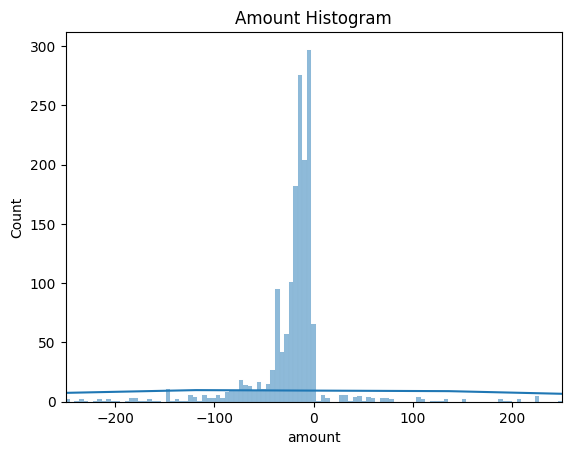

In [9]:
fig, ax = plt.subplots()
sns.histplot(shuffled_txns_df['amount'], ax=ax, kde=True)
ax.set_title('Amount Histogram')
ax.set_xlim([-250,250])

Let's use a robust scaler for amount actually since it ranges very far and has a lot of outliers. For the year column, we'll one hot encode the year since there are only three years (2022-2024). While we're doing this, we'll also one hot encode the source column since there are only four potential sources for my transactions (boa_debit, boa_credit, amex, and venmo).

In [ ]:
# use cyclic encoding to encode the cyclic nature of days of the week and month
shuffled_txns_df['dow_sin'] = np.sin(2 * np.pi * shuffled_txns_df['dow'] / 7)
shuffled_txns_df['dow_cos'] = np.cos(2 * np.pi * shuffled_txns_df['dow'] / 7)

shuffled_txns_df['month_sin'] = np.sin(2 * np.pi * shuffled_txns_df['month'] / 12)
shuffled_txns_df['month_cos'] = np.cos(2 * np.pi * shuffled_txns_df['month'] / 12)

# one hot encode the year and source
encoder = OneHotEncoder(sparse_output=False)
year_encoded = encoder.fit_transform(shuffled_txns_df[['year','source']])
year_encoded_df = pd.DataFrame(year_encoded, columns=encoder.get_feature_names_out(['year','source']))
shuffled_txns_df = pd.concat([shuffled_txns_df.drop(columns=['year','source']), year_encoded_df], axis=1)

# split the data 
X_train, X_temp, y_train, y_temp = train_test_split(shuffled_txns_df, y_onehot, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale 'dom' and 'year' using StandardScaler
scaler = StandardScaler()
scale_columns = ['dom']

num_scaled_train = pd.DataFrame(scaler.fit_transform(X_train[scale_columns]), columns=scale_columns, index=X_train.index)
num_scaled_val = pd.DataFrame(scaler.transform(X_val[scale_columns]), columns=scale_columns, index=X_val.index)
num_scaled_test = pd.DataFrame(scaler.transform(X_test[scale_columns]), columns=scale_columns, index=X_test.index)

# Replace the original 'dom' and 'year' columns with the scaled versions
train_scaled = pd.concat([X_train.drop(columns=scale_columns), num_scaled_train], axis=1)
val_scaled = pd.concat([X_val.drop(columns=scale_columns), num_scaled_val], axis=1)
test_scaled = pd.concat([X_test.drop(columns=scale_columns), num_scaled_test], axis=1)

# Use RobustScaler to scale and replace the 'amount' column
robust_scaler = RobustScaler()
amount_train = pd.Series(robust_scaler.fit_transform(X_train[['amount']]).flatten(), index=X_train.index, name='amount')
amount_val = pd.Series(robust_scaler.transform(X_val[['amount']]).flatten(), index=X_val.index, name='amount')
amount_test = pd.Series(robust_scaler.transform(X_test[['amount']]).flatten(), index=X_test.index, name='amount')

# Replace the original 'amount' column with the scaled version
train_scaled['amount'] = amount_train
val_scaled['amount'] = amount_val
test_scaled['amount'] = amount_test

train_scaled.head()

In [ ]:
# drop dow and dom
drop_columns = ['dow', 'month']
train_scaled = train_scaled.drop(columns=drop_columns)
val_scaled = val_scaled.drop(columns=drop_columns)
test_scaled = test_scaled.drop(columns=drop_columns)

train_scaled.head()

Now that we've dealt with all the numeric categories, we'll move onto the categorical features.

## Categorical Features

In [ ]:
cat_columns = ['description', 'extended_details', 'merchant', 'address', 'city', 'zip_code', 'category']

# lowercase all the columns and replace \n with spaces
for col in cat_columns:
    train_scaled[col] = train_scaled[col].str.lower().str.replace('\n',' ')
    val_scaled[col] = val_scaled[col].str.lower().str.replace('\n',' ')
    test_scaled[col] = test_scaled[col].str.lower().str.replace('\n',' ')

train_scaled.head()

We will be using word embeddings for our strings. To capture the whole transaction context, we will combine all of the strings together. The only one we won't combine is the source column as this will be one hot encoded.

In [ ]:
sum_columns = ['description', 'extended_details', 'merchant', 'address', 'city', 'state', 'zip_code', 'category']

# fill all NA values with blank strings for the next step
train_scaled[sum_columns] = train_scaled[sum_columns].fillna('')
val_scaled[sum_columns] = val_scaled[sum_columns].fillna('')
test_scaled[sum_columns] = test_scaled[sum_columns].fillna('')

# combine all string columns into one long text per transaction separated by a space
train_scaled['combined_text'] = train_scaled[sum_columns].agg(' '.join, axis=1)
val_scaled['combined_text'] = val_scaled[sum_columns].agg(' '.join, axis=1)
test_scaled['combined_text'] = test_scaled[sum_columns].agg(' '.join, axis=1)

# drop all the columns that were aggregated
train_scaled = train_scaled.drop(columns=sum_columns)
val_scaled = val_scaled.drop(columns=sum_columns)
test_scaled = test_scaled.drop(columns=sum_columns)

train_scaled.head()

In [14]:
# check for any null values
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1093 entries, 842 to 501
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   amount              1093 non-null   float64
 1   dow_sin             1093 non-null   float64
 2   dow_cos             1093 non-null   float64
 3   month_sin           1093 non-null   float64
 4   month_cos           1093 non-null   float64
 5   year_2022           1093 non-null   float64
 6   year_2023           1093 non-null   float64
 7   year_2024           1093 non-null   float64
 8   source_Venmo        1093 non-null   float64
 9   source_amex         1093 non-null   float64
 10  source_boa_credit   1093 non-null   float64
 11  source_boa_debit    1093 non-null   float64
 12  source_boa_savings  1093 non-null   float64
 13  dom                 1093 non-null   float64
 14  combined_text       1093 non-null   object 
dtypes: float64(14), object(1)
memory usage: 136.6+ KB


Our data is looking nearly ready! I'm going to preprocess the strings some more to make better embeddings. We will lose information like numbers, excess, whitespace, and punctuation in order to make our embedding vectors closer to the real thing. There's also some numbers that are directly connected to important information (ex: 57san jose) and we'd like the embedding to be able to tell san jose apart from other cities.  

In [15]:
# check range of lengths of the strings
print('Max Length String:\n',train_scaled['combined_text'][train_scaled['combined_text'].str.len().idxmax()])
print('Length of String:',train_scaled['combined_text'].str.len().max())
print('-'*150)
print('Min Length String:\n',train_scaled['combined_text'][train_scaled['combined_text'].str.len().idxmin()])
print('Length of String:',train_scaled['combined_text'].str.len().min())

Max Length String:
 air japan air japan japan               jp jlgb1b73316 airline/air carrier passenger ticket air japan air japan japan jp carrier : air japan passenger name : kenneth hahn ticket number : jlgb1b departure day : 11/05 additional info : passenger ticket from : tokyo narita apt to : seoul incheon inte from : seoul incheon inte to : tokyo narita aptforeign spend amount: 31090.00 japanese yen commission amount:  currency exchange rate: null air japan air japan japan               jp ana narita sky center 3b narita international airport narita   282-0005 travel-airline
Length of String: 568
------------------------------------------------------------------------------------------------------------------------------------------------------
Min Length String:
 standard transfer       
Length of String: 24


We will now preprocess the text by removing punctuation, numeric values, and extra whitespace. Also, we'll remove repeated words as several of the columns that we combined had the same information and it does not add any value to keep the same information multiple times.

In [16]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]',' ', text) # remove punctuation
    text = re.sub(r'\d+','',text) # remove numeric values
    text = re.sub(r'\s+',' ',text).strip() # remove extra whitespace

    # remove repeated words
    words = text.split()
    unique_words = list(dict.fromkeys(words))

    return ' '.join(unique_words)

train_scaled['combined_text'] = train_scaled['combined_text'].apply(preprocess_text)
val_scaled['combined_text'] = val_scaled['combined_text'].apply(preprocess_text)
test_scaled['combined_text'] = test_scaled['combined_text'].apply(preprocess_text)

# recheck range of lengths of the longest and shortest strings
print('Max Length String:\n',train_scaled['combined_text'][train_scaled['combined_text'].str.len().idxmax()])
print('Length of String:',train_scaled['combined_text'].str.len().max())
print('-'*150)
print('Min Length String:\n',train_scaled['combined_text'][train_scaled['combined_text'].str.len().idxmin()])
print('Length of String:',train_scaled['combined_text'].str.len().min())


Max Length String:
 air japan jp jlgbb airline carrier passenger ticket name kenneth hahn number departure day additional info from tokyo narita apt to seoul incheon inte aptforeign spend amount japanese yen commission currency exchange rate null ana sky center b international airport travel
Length of String: 272
------------------------------------------------------------------------------------------------------------------------------------------------------
Min Length String:
 standard transfer
Length of String: 17


### Embeddings  

Now let's move onto embeddings our combined_text. We'll start off using DistilBert becuase it's more compact and my system does not have a lot of compute.

In [17]:
# using distilbert for embeddings
model_id = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = TFAutoModel.from_pretrained(model_id)

def embed_bert(text):
    """Output the embedding matrix using pretrained model for the combined_text Series"""
    inputs = tokenizer(text.tolist(), return_tensors='tf', padding=True, truncation=True, max_length=128)
    outputs = model(inputs)
    embeddings = outputs.last_hidden_state
    embeddings = tf.reduce_mean(embeddings, axis=1) # global avg pooling
    return embeddings

# embed the data
train_embeddings = embed_bert(train_scaled['combined_text'])
val_embeddings = embed_bert(val_scaled['combined_text'])
test_embeddings = embed_bert(test_scaled['combined_text'])

# print the shape
print(f"Train Embedding Shape: {train_embeddings.shape}")
print(f"Validation Embeddings Shape: {val_embeddings.shape}")
print(f"Test Embeddings Shape: {test_embeddings.shape}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Train Embedding Shape: (1093, 768)
Validation Embeddings Shape: (364, 768)
Test Embeddings Shape: (365, 768)


# Create Baseline Models  

Let's create some baseline models to compare our final model to. Let's first finalize our inputs and labels into a singular format for simpler use later on. Afterward we'll see the validation accuracy for a Majority Class Classifier, Logistic Regression, RandomForestClassifier, and a Support Vector Machine.

In [18]:
# drop combined text columns since we embedded it
X_train_other = train_scaled.drop(columns='combined_text').to_numpy()
X_val_other = val_scaled.drop(columns='combined_text').to_numpy()
X_test_other = test_scaled.drop(columns='combined_text').to_numpy()

# change embeddings to numpy
X_train_embeddings = train_embeddings.numpy()
X_val_embeddings = val_embeddings.numpy()
X_test_embeddings = test_embeddings.numpy()

# concatenate the two arrays
X_train_concat = np.concatenate([X_train_embeddings, X_train_other], axis=1)
X_val_concat = np.concatenate([X_val_embeddings, X_val_other], axis=1)
X_test_concat = np.concatenate([X_test_embeddings, X_test_other], axis=1)

# print shape
print('X_train shape:',X_train_concat.shape)
print('X_val shape:',X_val_concat.shape)
print('X_test shape:', X_test_concat.shape)

X_train shape: (1093, 782)
X_val shape: (364, 782)
X_test shape: (365, 782)


## Majority Class Classifier

In [19]:
# find the majority class and the distributions
majority_class = y_train.sum(axis=0).argmax()
class_distribution = y_train.sum(axis=0)/y_train.sum()
class_labels = label_encoder.classes_

print('Majority Class:', class_labels[majority_class])
print('Majority Class Training Accuracy:', class_distribution.max())
print('Class Distribution Percentage:', class_distribution)
print('Class Labels:', class_labels)

# create majority class predictions with the validation data
majority_class_pred_val = np.full((y_val.shape[0],), majority_class)
y_val_true = y_val.argmax(axis=1)

# calculate the accuracy
majority_class_val_accuracy = accuracy_score(y_val_true, majority_class_pred_val)

print('Majority Class Validation Accuracy:', majority_class_val_accuracy)

Majority Class: dining
Majority Class Training Accuracy: 0.43824336688014637
Class Distribution Percentage: [0.00914913 0.43824337 0.00091491 0.0558097  0.00365965 0.04574565
 0.00091491 0.00365965 0.07227813 0.01280878 0.00548948 0.01280878
 0.00182983 0.04666057 0.04483074 0.03202196 0.15645014 0.03659652
 0.02012809]
Class Labels: ['debt' 'dining' 'education' 'entertainment' 'fees' 'groceries'
 'healthcare' 'housing' 'ignore' 'income' 'insurance' 'investments' 'misc'
 'personal_care' 'shopping' 'subscriptions' 'transportation' 'travel'
 'utilities']
Majority Class Validation Accuracy: 0.43956043956043955


Majority Class doesn't do too great but at least we know that the validation and training accuracy have nearly the same majority class percentage.  

## Logistic Regression

In [20]:
# create and fit LogisticRegression model (found that it only converged after a lot of iterations)
log_regression = LogisticRegression(max_iter=2500)
log_regression.fit(X_train_concat, y_train.argmax(axis=1))

# predict and calculate accuracy for training data
log_reg_train_pred = log_regression.predict(X_train_concat)
y_train_true = y_train.argmax(axis=1)
log_reg_accuracy_train = accuracy_score(y_train_true, log_reg_train_pred)

# predict and calculate accuracy for validation data
log_reg_val_pred = log_regression.predict(X_val_concat)
log_reg_accuracy_val = accuracy_score(y_val_true, log_reg_val_pred)

print('Logistic Regression Training Accuracy:', log_reg_accuracy_train)
print('Logistic Regression Validation Accuracy:', log_reg_accuracy_val)


Logistic Regression Training Accuracy: 0.9954254345837146
Logistic Regression Validation Accuracy: 0.9258241758241759


Seems like my data is very linear! Also the default l2 regularization is reducing the feature space so overall, we may just want to go with this option (especially since the number of datapoints is low). Due to the fact that my categories are very imbalanced (my lowest category only has two data points with that label), I will not be cross validating the models. I will revisit this once I have more datapoints.

## Random Forest Classifier

In [21]:
# try a simple RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=500, random_state=42)
random_forest.fit(X_train_concat, y_train.argmax(axis=1))

# predict and calculate accuracy
rf_val_pred = random_forest.predict(X_val_concat)
rf_accuracy = accuracy_score(y_val_true, rf_val_pred)

print("Random Forest Model Validation Accuracy:", rf_accuracy)

Random Forest Model Validation Accuracy: 0.8928571428571429


Not as good as Logisitic regression, which makes sense since the feature space is so big.

## Support Vector Machine

In [22]:
# use SVC with a linear kernel (probability=True is used for later in the notebook)
# we saw that logistic regressions with some regularization helped so we'll copy the same process but with SVC
svm_model = SVC(kernel='linear', C=.09, random_state=42, probability=True)
svm_model.fit(X_train_concat, y_train.argmax(axis=1))

# create predictions and calculate accuracy
y_train_pred = svm_model.predict(X_train_concat)
y_val_pred = svm_model.predict(X_val_concat)

svm_train_accuracy = accuracy_score(y_train.argmax(axis=1), y_train_pred)
svm_val_accuracy = accuracy_score(y_val.argmax(axis=1), y_val_pred)

print('SVC Train Accuracy:', svm_train_accuracy)
print('SVC Validation Accuracy:', svm_val_accuracy)

SVC Train Accuracy: 0.969807868252516
SVC Validation Accuracy: 0.9258241758241759


It seems like SVC does just as well on the validation data as our logistic regression; however, it seems to be overfitting less, which may make this our best model yet.

# Deep Neural Network  

I will now attempt to create a deep neural network that beats the performance of my baseline models. However, I expect that it won't do as well as the linear models since my dataset is extremely small. But it would be good to see the performance and reimplement this model once I've collected more data.

In [ ]:
def build_model(embeddings_shape, other_features_shape, num_categories, learning_rate):
    """Build a Neural Network that will take an embedding tensor and a tensor with the other features (price, source, etc).
    The model will then process them differently. The embedding tensor will go through a reduction layer to reduce the size to 150 neurons.
    The other_features will go through a Dense layer first. Then they will be concatenated and go through a shallow network to learn.

    Params:
    ------------------------------------------
    embeddings_shape (int): number of features in the embeddings array
    other_features_shape (int): number of features in the other_features array
    num_categories (int): number of classes
    learning_rate (float): the learning rate for the optimizer.

    Returns:
    ------------------------------------------
    model (tf model): a classification model that takes an embedding tensor and a tensor of other useful features to classify bank transactions into distinct categories.
    """
    # create input layers
    embeddings_input = tf.keras.layers.Input(shape=(embeddings_shape,))
    other_features_input = tf.keras.layers.Input(shape=(other_features_shape,))

    # reduce the size of the embeddings tensor to 150 neurons
    reduction_layer = tf.keras.layers.Dense(150, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(embeddings_input)

    # train the model on just the other_features separately first
    other_features_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(other_features_input)
    other_features_layer = tf.keras.layers.Dropout(0.1)(other_features_layer)

    # concatenate the other_features and the embeddings
    concat_layer = tf.keras.layers.concatenate([reduction_layer, other_features_layer])

    # go through one Dense layer with Dropout
    dense_layer = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(concat_layer)
    dropout_layer = tf.keras.layers.Dropout(0.1)(dense_layer)

    # output with the num_categories using softmax
    output_layer = tf.keras.layers.Dense(num_categories, activation='softmax')(dropout_layer)

    # build the model
    model = tf.keras.Model(inputs=[embeddings_input, other_features_input], outputs=output_layer)

    # specify the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def fit_model(model, train_embeddings, X_train_other, val_embeddings, X_val_other, y_train, y_val, epochs, batch_size):
    """
    Train the model and output a loss vs. epochs scatterplot and lineplot.

    Parameters:
    model: TensorFlow/Keras model
    train_embeddings: numpy array for training embeddings
    X_train_other: numpy array for additional training features
    val_embeddings: numpy array for validation embeddings
    X_val_other: numpy array for additional validation features
    y_train: numpy array for training labels
    y_val: numpy array for validation labels
    epochs: int, number of epochs to train
    batch_size: int, batch size for training

    Returns:
    history: History object from model training
    """
    # Set up early stopping and checkpoint callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model.fit(
        x=[train_embeddings, X_train_other],
        y=y_train,
        validation_data=([val_embeddings, X_val_other], y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # Plot loss vs epochs
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = np.arange(len(train_loss))

    plt.figure(figsize=(10, 6))

    # Scatter plot for training and validation loss
    plt.scatter(epochs_range, train_loss, color='blue', label='Training Loss', alpha=0.6)
    plt.scatter(epochs_range, val_loss, color='red', label='Validation Loss', alpha=0.6)

    # Line plot for smoother visualization
    plt.plot(epochs_range, train_loss, color='blue', linestyle='-', label='Training Loss (line)')
    plt.plot(epochs_range, val_loss, color='red', linestyle='-', label='Validation Loss (line)')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epochs')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    return history

Epoch 1/1000
547/547 [==============================] - 17s 4ms/step - loss: 7.5172 - accuracy: 0.2598 - val_loss: 6.8672 - val_accuracy: 0.4451
Epoch 2/1000
547/547 [==============================] - 2s 3ms/step - loss: 6.7398 - accuracy: 0.4501 - val_loss: 6.2836 - val_accuracy: 0.4451
Epoch 3/1000
547/547 [==============================] - 2s 3ms/step - loss: 6.2520 - accuracy: 0.4648 - val_loss: 5.9480 - val_accuracy: 0.4835
Epoch 4/1000
547/547 [==============================] - 2s 3ms/step - loss: 5.8586 - accuracy: 0.4959 - val_loss: 5.6879 - val_accuracy: 0.5330
Epoch 5/1000
547/547 [==============================] - 2s 3ms/step - loss: 5.7955 - accuracy: 0.5252 - val_loss: 5.4526 - val_accuracy: 0.5604
Epoch 6/1000
547/547 [==============================] - 2s 3ms/step - loss: 5.4974 - accuracy: 0.5416 - val_loss: 5.2529 - val_accuracy: 0.5769
Epoch 7/1000
547/547 [==============================] - 2s 3ms/step - loss: 5.4319 - accuracy: 0.5517 - val_loss: 5.0750 - val_accuracy

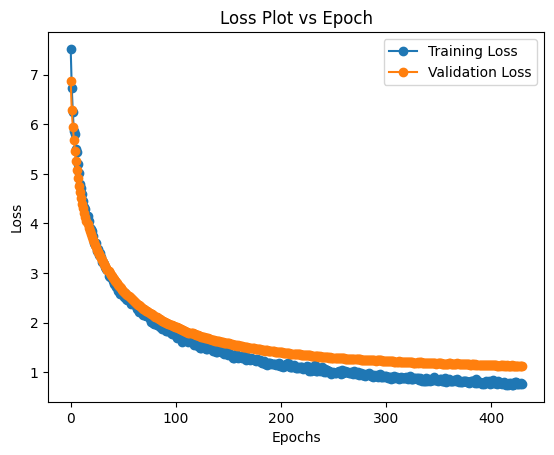

In [24]:
model = build_model(train_embeddings.shape[1], X_train_other.shape[1], y_train.shape[1], learning_rate=0.00001)

history = fit_model(model, train_embeddings, X_train_other,
                    val_embeddings, X_val_other, y_train, y_val, 1000,2)

In [25]:
nn_y_pred_train = model.predict([X_train_embeddings, X_train_other])
nn_y_pred_val = model.predict([X_val_embeddings, X_val_other])

nn_train_accuracy = accuracy_score(y_train.argmax(axis=1), nn_y_pred_train.argmax(axis=1))
nn_val_accuracy = accuracy_score(y_val.argmax(axis=1), nn_y_pred_val.argmax(axis=1))

print('Neural Network Training Accuracy:', nn_train_accuracy)
print('Neural Network Validation Accuracy:', nn_val_accuracy)

12/12 [==============================] - 0s 2ms/step
Neural Network Training Accuracy: 0.9762122598353157
Neural Network Validation Accuracy: 0.9148351648351648


 Overall it looks like the neural network is comparable to the SVM. This could mean that this model could get better with more labelled data. However for now, maybe it's better to just stick with SVM.  

 Second to last step, I'll try to combine my three best models (logisitc regression, SVM, and my NN) and see if an ensembling method will help the accuracy out some more.

# Putting it all together  

Ensembling could help here since all three of my models do well individually so the overall model might learn things from different models. Since our NN requires two different inputs (an embedding tensor and a tensor of other features), we'll just use a soft voting ensembler to make it easier.

In [26]:
# calculate prediction probabilities of logistic regression
log_reg_proba_train = log_regression.predict_proba(X_train_concat)
log_reg_proba_val = log_regression.predict_proba(X_val_concat)

# calculate prediction probabilities of svc
svm_proba_train = svm_model.predict_proba(X_train_concat)
svm_proba_val = svm_model.predict_proba(X_val_concat)

# calculate the prediction probabilities from the deep neural network
dnn_proba_train = model.predict([X_train_embeddings, X_train_other])
dnn_proba_val = model.predict([X_val_embeddings, X_val_other])

# take the average of the predictions for training and validation accuracies
combined_proba_train = (log_reg_proba_train + svm_proba_train + dnn_proba_train) / 3
combined_pred_train = np.argmax(combined_proba_train, axis=1)
combined_proba_val = (log_reg_proba_val + svm_proba_val + dnn_proba_val) / 3
combined_pred_val = np.argmax(combined_proba_val, axis=1)

# calculate the accuracies of the ensembled models
accuracy_train = accuracy_score(y_train.argmax(axis=1), combined_pred_train)
accuracy_val = accuracy_score(y_val.argmax(axis=1), combined_pred_val)

print('Voting Classifier Training Accuracy:', accuracy_train)
print('Voting Classifier Validation Accuracy', accuracy_val)


12/12 [==============================] - 0s 2ms/step
Voting Classifier Training Accuracy: 0.9807868252516011
Voting Classifier Validation Accuracy 0.9258241758241759


Our model does just about the same. I'm going to keep it ensembled like this as I can only assume that the model will do better with more data (especially the Neural Network). I also have run this a couple times now and the ensemble model does seem to do better on some runs but about the same as the consituent models on other runs. Regardless, let's put this ensembling as one function to call easier later.

In [27]:
def ensemble_scores_and_predictions(models, dnn_model, X_embeddings, X_other, y):
    """Takes a list of models as well as a neural network and creates and ensemble prediction and score.
    Params:
    ----------------------------
    models (list): a list of already fitted models that takes the whole X dataset
        - the models must output a probability distribution for the classes
    dnn_model (tf model): this is a neural network model that takes inputs [X_embeddings, X_other]
    X_embeddings (np array): an array of only the embeddings
    X_other (np array): an array of all other features
    y: the y_values

    Returns:
    ----------------------------
    combined_pred (np array): the array of all the predictions for X_embeddings and X_other
    accuracy (float): the accuracy of the ensemble
    """
    X_concat = np.concatenate([X_embeddings, X_other], axis=1)
    X_dnn = [X_embeddings, X_other]

    models_probas = [model.predict_proba(X_concat) for model in models]
    models_probas.append(dnn_model.predict(X_dnn))

    num_models = len(models_probas)
    combined_proba = 0

    for proba in models_probas:
        combined_proba += proba
    
    combined_proba /= 3
    combined_pred = combined_proba.argmax(axis=1)
    accuracy = accuracy_score(y, combined_pred)

    return combined_pred, accuracy

# recheck predictions and accuracy on validation data to ensure it matches the above cell
predictions, final_accuracy = ensemble_scores_and_predictions([log_regression, svm_model], model, X_val_embeddings, X_val_other, y_val.argmax(axis=1))

print(f'All Predictions:\n{predictions}')
print(f'Final Accuracy: {final_accuracy}')

12/12 [==============================] - 0s 2ms/step
All Predictions:
[17  1  8  8  8 16  8  0  1  9  1 18  1  1 14 18  1  1  1  1  1  8  3  1
  1  1  1 13  8 16 16 13  1  1  3  1  1  1  1  1  1  1 14  1  1 16  1 16
  8  3 16  1  0 16  1  1 17 16 14  8  1  3  1  3  1  3 13 10  5 16  1  8
  1  1  1 13 18  5  3  1  1 16 18  1  8  1  5 17  1  1  7  1 16 13 15  1
 15  5 16 16  1  1  1  1 15 16 14  5  1  8 11  1  5  1 17  1  4  5 15  1
  8  3 15  1 16  3 16  5  8 16  1  1 16  1  8  1  1 16  1  1  5  8 17  1
 16 14  1 10  1  3 16  1  1 14 16 17  1  3 16  1  1  9 11  1 18  1 10  5
 16  1  1  1 16  3  0  5 16  1  5 15  1  8 17  1  1  1 16 13  1  8  1  1
  1 16 17 10 18  1  8  8 16  1 14  1 15  1  1  1  8  1  1  1  1  1  1  1
  1 13 18  1  1  1  1 18  1  1  1  1  1  1  1  1  1  3 17  8  9  1 16 16
 14  1  1  3  1  1 16  8  5 16  1  1  1  1  1 16 14 13  1  9 15  1  8  3
  9 16  5  8 16 14 16  1  1 16  1 17 14  1 16  8  1  1  1  3  1  1 16 16
  1  1  1  5  1 16  1  1  1 15  1  1 13  1  3  1  8  8

# Final Evaluation of Model  

Now that we've chosen a final model. Let's use this on our test data and see what the metrics look like.

In [28]:
# get the predictions and the accuracy for the test data
test_pred, test_accuracy = ensemble_scores_and_predictions([log_regression, svm_model], model, X_test_embeddings, X_test_other, y_test.argmax(axis=1))

print(f'Test Predictions:\n{test_pred}')
print(f'Test Accuracy: {test_accuracy}')

12/12 [==============================] - 0s 2ms/step
Test Predictions:
[ 1  1  1  1  8 18  8  9  1  1  5 16  8  1 16  1 16 16  8  1  1 17  1 10
  1  1 16 13  1  1 17  1  1  1  1 16 16 13  3  1  1  5  3  1 15  1  9 16
  1  8  1 13 11  1  1  7  0  1  1  9  1 11  1  3  1  1  1 16  1  1 13 14
 16  5 14  5 13 16  1  0 18  0 16  1  1  3  1 17  5  1  1  1  8  1  1 13
 14  8  5  1  1  1  1 16 16  1 13  1 16  8  2  5 18  8  1  1  1  1 16  1
 16 16 16  1  1  1  1  8 16  0  1 13  1  8  1 13  1 15  3  1  1  1 16  0
  1 17  1  1  1  1  1  1  1  3 14  1  1 18  1 16  1  1 14 13  1 16 16  1
  1 11 18 16  8  1  1 18  1  1  2  8  1  8  1 14 16 18  5 13  8  1  8 14
  1  1  1 13  8  1 13 15 17 16  5  1  7 16  5  5  1  1  5 16 11  1  8  1
 13 16 13  1  1  1  3  1 16  1  1 16  8  1 18  8 14  8  8 10 14  8  8 18
 16 16  1 13 18 17  5  3  1  1  1 16  8  1 17  1  1 16  1  1 18  1  3 14
  1  1  1  2 16  1  1  1  1  1  9 13  1  1 16  1  1  8 15 17  1 16  1  1
 14  1  5  1 13 17  1  1  1  1 14  8  1  1  1  1 17  

Overall the test accuracy is not as great, which is expected. I can accept a ~90% test accuracy for now, especially since we'll be getting more data over time.  

Let's look at the confusion matrix for better clarity.

<Figure size 1000x1000 with 0 Axes>

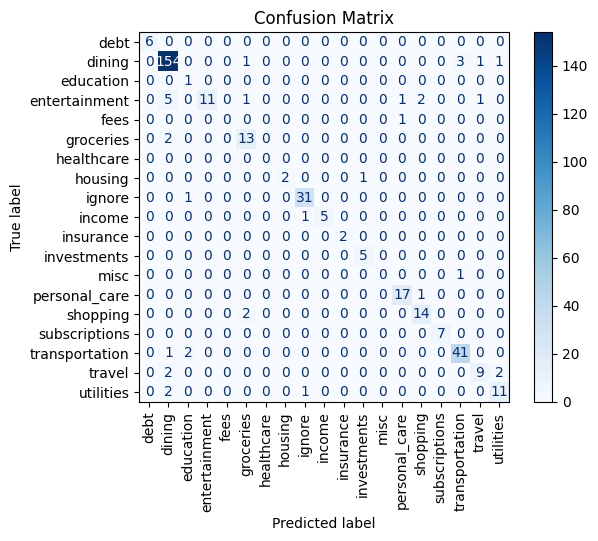

In [30]:
# create confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), test_pred, labels=np.arange(len(label_encoder.classes_)))

# plot confusion matrix
plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

In [31]:
# print report to view precision, recall, and f1-score
print(classification_report(
    y_test.argmax(axis=1), 
    test_pred,
    labels=np.arange(len(label_encoder.classes_)),
    target_names=label_encoder.classes_,
    zero_division=0
    ))

                precision    recall  f1-score   support

          debt       1.00      1.00      1.00         6
        dining       0.93      0.96      0.94       160
     education       0.25      1.00      0.40         1
 entertainment       1.00      0.52      0.69        21
          fees       0.00      0.00      0.00         1
     groceries       0.76      0.87      0.81        15
    healthcare       0.00      0.00      0.00         0
       housing       1.00      0.67      0.80         3
        ignore       0.94      0.97      0.95        32
        income       1.00      0.83      0.91         6
     insurance       1.00      1.00      1.00         2
   investments       0.83      1.00      0.91         5
          misc       0.00      0.00      0.00         1
 personal_care       0.89      0.94      0.92        18
      shopping       0.82      0.88      0.85        16
 subscriptions       1.00      1.00      1.00         7
transportation       0.91      0.93      0.92  

Overall, it seems that my model does perfectly with the debt, insurance, and subscriptions categories and does really poorly with the education, entertainment and travel categories. The model did not even predict the fees, misc, or healthcare categores.  

Fees, misc, healthcare, and education all make sense as these have EXTREMELY few datapoints to go off of.  

The travel is being mistaken as the dining category, which also makes sense as I may have mistakenly labelled some dining purchases as travel purchases while I was travelling. Either way, I'm okay with mistaking these two categories from one another.  

Now entertainment is interesting because there is a decent amount of data available for training so I'll take a look at that one.

In [ ]:
pd.set_option('display.max_colwidth', None)

# put the predictions and labels into the original DataFrame to see the data alongside with the predictions
test_scaled['label_pred'] = label_encoder.classes_[test_pred]
test_scaled['labels'] = label_encoder.classes_[y_test.argmax(axis=1)]

# find the labels marked as 'entertainment' and where the predictions and the labels don't match 
test_scaled[(test_scaled['labels'] != test_scaled['label_pred']) & (test_scaled['labels']=='entertainment')][['combined_text', 'labels', 'label_pred']]

It seems that the combined_text isn't taking into account emojis, which is quite prevalent in venmo transactions and so it's just assuming that venmo requests are dining, which makes sense.  

the other ones that it got wrong was that it saw the word restaurant and assumed it was for dining (which makes sense); however, for example Paper Plane or Emporium are bars and I categorized it as entertainment as I didn't really eat there. Either way, it is interesting that it could still understand the words and label it as dining. I won't fault the model for mixing those up.

# Next Steps  

Overall, I think this classifier was a success! I will continue to update it; however, the next steps are as follows:  

1. Refactor this code so it can run automatically.  
2. Create a dashboard app to see all of the data easily and be able to retrain the model on a regular basis.  
3. Collect more data and retrain.  
4. Repeat and Repeat.